In [24]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import utils as utl
import html_evaluation_portfolio as hep
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img

## Importing and processing data

In [25]:
#set overall parameters (list opf securities and window of days on which you compute the volatility on)
list_securities = ['TMF', 'UPRO', 'TYD', 'UTSL', 'UGL'] #DIG
window = 30 #days

In [26]:
unique_name = ''
for i in list_securities:
    unique_name += '_' + i
    
#main
data = hep.create_dataframe(list_securities) #I can import this dataframe but it is preatty fast.
#print(data)
data_perc = hep.perc_df(data)
inv_volat_data = hep.df_inverse_volatility(data_perc, window)
data_wheighted = hep.df_wheighted(inv_volat_data)
data_earnings = hep.df_earnings(data_wheighted, data_perc)
data_earn_eq_weight = hep.df_earnings_equal_weight(data_perc)
data_earnings.dropna(inplace = True)
data_earn_eq_weight.dropna(inplace = True)
display(data_earn_eq_weight)

,TMF,UPRO,TYD,UTSL,UGL,Tot
Date,,,,,,
2017-05-04,-0.003610,0.000479,-0.002165,-0.001507,-0.005152,-0.011955
2017-05-05,0.000262,0.003146,0.000345,0.006346,0.000809,0.010908
2017-05-08,-0.003790,-0.000149,-0.001607,-0.000384,-0.000739,-0.006670
2017-05-09,-0.000265,-0.000671,-0.002022,-0.003346,-0.002562,-0.008867
2017-05-10,-0.000797,0.001147,0.002853,0.000000,-0.000545,0.002659
...,...,...,...,...,...,...
2022-03-23,0.016584,-0.009520,0.003065,0.001922,0.006711,0.018762
2022-03-24,-0.006221,0.011074,-0.002038,0.008017,0.004071,0.014903
2022-03-25,-0.009702,0.003759,-0.008631,0.010649,-0.002205,-0.006130


## Create and export plot for the report

#### Table of returns:

In [27]:
#param
figsize=(10, 5.5)
fontname = 'Arial'
annot_size=10
square = False
cbar = False
cmap = LinearSegmentedColormap.from_list('RedGreen', ['crimson', 'gold', 'lime'])
eoy = False
compounded = True

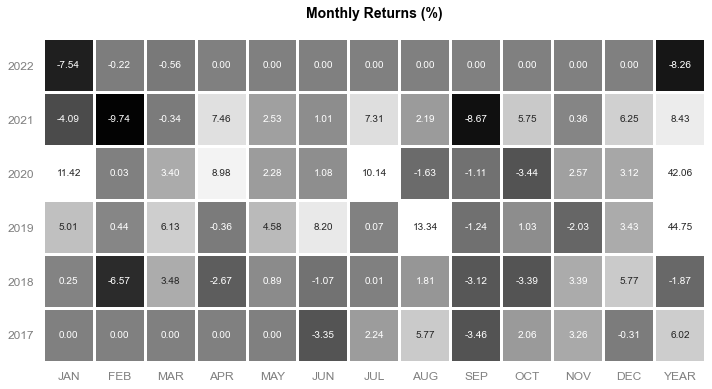

In [28]:
#crate the returns table plus the return over the year

fig, ax = plt.subplots(figsize=figsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Monthly Returns (%)\n', fontsize=14, y=.995,
             fontname=fontname, fontweight='bold', color='black')

returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

#print(returns.div(100).add(1).cumprod(axis = 1)) #replace(0,1).cumprod(axis=1)['DEC']
returns['YEAR'] = returns.div(100).add(1).cumprod(axis = 1)['DEC']
returns['YEAR'] = returns['YEAR'].sub(1).mul(100)

reversed_df = returns.iloc[::-1]

#display(returns)

ax = sns.heatmap(reversed_df, ax=ax, annot=True, center=0,
                annot_kws={"size": annot_size}, vmax = 10,
                fmt="0.2f", linewidths=2,
                square=square, cbar=cbar, cmap = 'gray',
                cbar_kws={'format': '%.0f%%'})

ax.tick_params(colors="#808080")
plt.xticks(rotation=0, fontsize=annot_size*1.2)
plt.yticks(rotation=0, fontsize=annot_size*1.2)
plt.subplots_adjust(hspace=0, bottom=0, top=1)
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig('./img/temp/table_montly_returns' + unique_name + '.png')
fig_table = fig 

#### Distribution plot:

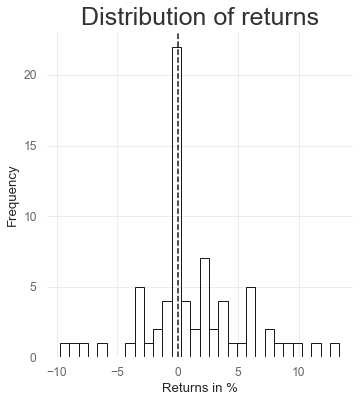

In [29]:
returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

series = pd.Series(dtype = 'float64')
for column in returns.columns:
    series = pd.concat([series,returns[column]])
#distribution(returns)
ax = series.plot.hist(bins = 30, edgecolor='k',fill=False)
ax.set_title('Distribution of returns', size = 25)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel("Returns in %")
ax.set_ylabel("Frequency")
fig = ax.get_figure()
fig.set_size_inches(5.5,6)
fig.savefig('./img/temp/distribution_returns' + unique_name + '.png')
fig_distribution = fig

#### Table of statistics:

In [30]:
# create table of stats

statistics = pd.DataFrame(columns = ['index', 'value'])

statistics.loc[0] = ['Annualised return', utl.annualized_return(data_earnings['Tot'])]
statistics.loc[1] = ['Annualised volatility', utl.annualised_volatility(data_earnings['Tot'])]
statistics.loc[2] = ['Sharpe ratio', sharpe(data_earnings['Tot'])]
statistics.loc[3] = ['Sortino ratio', sortino(data_earnings['Tot'])]
statistics.loc[4] = ['Adjusted sortino', adjusted_sortino(data_earnings['Tot'])] 
statistics.loc[5] = ['Skew', skew(data_earnings['Tot'])] 
statistics.loc[6] = ['Kurtosis', data_earnings['Tot'].kurt()] 
statistics.loc[7] = ['Max drawdown', max_drawdown(data_earnings['Tot'])] 
statistics.loc[8] = ['GPR', gain_to_pain_ratio(data_earnings['Tot'])] 
statistics.loc[9] = ['Calmar ratio', calmar(data_earnings['Tot'])] 
statistics.loc[10] = ['Pay-off ratio', payoff_ratio(data_earnings['Tot'])] 

# Annualised return (At top)
# Annualizwed volatility (At top)

#export as .csv
statistics.to_csv('./data/temp/statistics_all_weather' + unique_name + '.csv')

statistics


,index,value
0,Annualised return,0.172386
1,Annualised volatility,0.170857
2,Sharpe ratio,1.009373
3,Sortino ratio,1.426545
4,Adjusted sortino,1.008719
5,Skew,-0.517635
6,Kurtosis,6.314807
7,Max drawdown,-0.231138
8,GPR,0.191207
9,Calmar ratio,0.739132


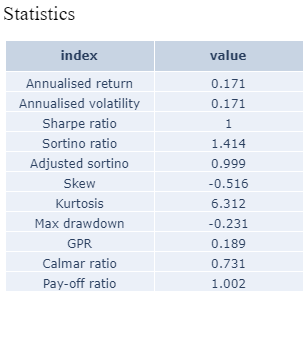

In [78]:
#transform pd. dataframe to image

fig = df2img.plot_dataframe(
    statistics.round(3),
    print_index=False,
    title=dict(
        font_color="black",
        font_family="Times New Roman",
        font_size=20,
        text="Statistics"),
    fig_size=(308, 338),

   )

df2img.save_dataframe(fig=fig, filename='./img/temp/statistics_all_weather' + unique_name + '.png')

fig_stats = fig
#statistics.to_csv('./img/temp/statistics_all_weather' + unique_name + '.csv')


#### Drawdown and underwater plots:

In [48]:
# Create benchmark portfolio (classic 60/40)

benchmark_portf = hep.create_dataframe(['TIP', 'SSO'])
benchmark_portf.dropna(inplace = True)
benchmark_portf_perc = hep.perc_df(benchmark_portf)
benchmark_portf_weight = pd.DataFrame()
benchmark_portf_weight['TIP'] = benchmark_portf_perc['TIP'] * 0.4
benchmark_portf_weight['SSO'] = benchmark_portf_perc['SSO'] * 0.6
#benchmark_portf_weight['TOT'] = benchmark_portf_weight.sum(axis=1)
#benchmark_portf_weight.dropna(inplace = True)
benchmark_earnings = hep.df_earnings(benchmark_portf_weight, benchmark_portf_perc)
benchmark_portf_perc['TOT'] = benchmark_portf_perc.sum(axis=1)
benchmark_portf_perc.dropna(inplace = True)
benchmark_portf_perc = benchmark_portf_perc[-len(data_earnings):] #as big as the all weather one

In [46]:
# Param
grayscale=True 
figsize= (10, 5.5)
fontname='Arial' 
lw=1
log_scale=False
match_volatility=False
compound=False
ylabel="Drawdown"
resample=None 
subtitle=True 
savefig =  './img/temp/under_water_plot' + unique_name + '.png'
show=True

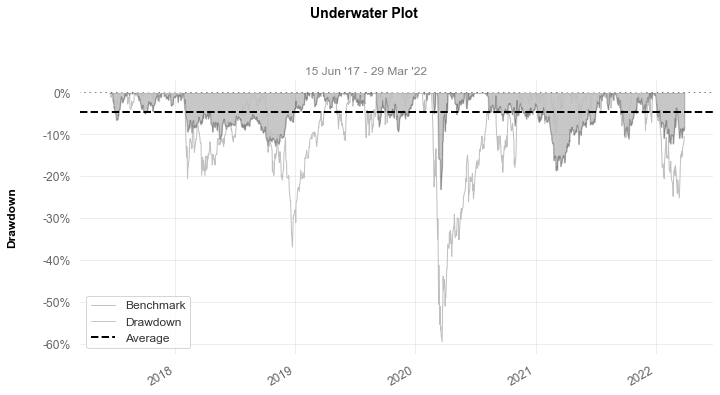

In [49]:
from quantstats._plotting.core import plot_timeseries

dd = to_drawdown_series(data_earnings['Tot'])
bench_dd = to_drawdown_series(benchmark_portf_perc['TOT'])

fig = plot_timeseries(dd,bench_dd, title='Underwater Plot',
                            hline=dd.mean(), hlw=2, hllabel="Average",
                            returns_label="Drawdown",
                            compound=compound, match_volatility=match_volatility,
                            log_scale=log_scale, resample=resample,
                            fill=True, lw=lw, figsize=figsize,
                            ylabel=ylabel,
                            fontname=fontname, grayscale=grayscale,
                            subtitle=subtitle,
                            savefig=savefig, show=show)
fig

## Combine the plots and create a figure

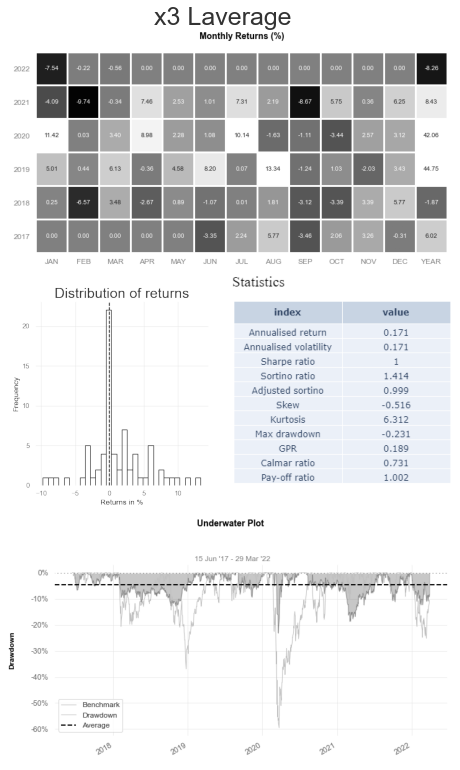

In [60]:
fig = plt.figure(figsize=(8, 13.55))

gs = gridspec.GridSpec(3, 2, wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0, :])
fig_table = plt.imread('./img/temp/table_montly_returns' + unique_name + '.png')
ax1.imshow(fig_table)
ax1.set_aspect('equal')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

ax2 = plt.subplot(gs[1,:1])
fig_distribiution = plt.imread('./img/temp/distribution_returns' + unique_name + '.png')
ax2.imshow(fig_distribiution)
ax2.set_aspect('equal')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(False)

ax3 = plt.subplot(gs[1, 1:])
fig_stats = plt.imread('./img/temp/statistics_all_weather' + unique_name + '.png')
ax3.imshow(fig_stats)
ax3.set_aspect('equal')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.grid(False)
    
ax4 = plt.subplot(gs[-1,:])
fig_underwater = plt.imread('./img/temp/under_water_plot' + unique_name + '.png')
ax4.imshow(fig_underwater)
ax4.set_aspect('equal')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.grid(False)

fig.suptitle('x3 Laverage', fontsize=25, y = 0.9 )

plt.savefig('reports/report' + unique_name + '.png', dpi = 1200)